#AllLife Bank Customer Segmentation

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

#Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

#Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

#Data Dictionary
- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [ ]:
!pip install yellowbrick

In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the silhouette scores
from yellowbrick.cluster import  SilhouetteVisualizer
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read the dataset

In [ ]:
# loading the dataset
data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning/Project6/CreditCardCustomerData.xlsx")

In [ ]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
# Make a copy to retain the original dataset
ccardDf = data.copy()

### View the first and last 5 rows of the dataset.

In [ ]:
ccardDf.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [ ]:
ccardDf.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


### Understand the shape of the dataset.

In [ ]:
ccardDf.shape

(660, 7)

* Dataset has 660 rows and 7 columns.

### Check the data types of the columns for the dataset.

In [ ]:
ccardDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


All the columns are of integer data type.

##Initial Data Analysis and Data Pre-Processing



### Check for missing values and duplicates

In [ ]:
ccardDf.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no missing values in the dataset.

In [ ]:
ccardDf.duplicated().any()

False

* There are no missing values or duplicates in the data.

By observing the top  and last 5 records in this dataset Sl_No column looks like a unique identifier for the customer data which may not be significant for our analysis, so we can drop this column.

In [ ]:
# we do not need the Sl_No column here, since it is not related to any of the columns, so this can be dropped
ccardDf.drop("Sl_No", axis=1, inplace=True)

Check the `Customer Key` column to determine if it is required in our analysis or not.

In [ ]:
ccardDf["Customer Key"].duplicated().sum()

5

There are 655 unique values of Customer key, so it looks like there are 5 duplicate keys in this dataset. Let us futher explore and see what has to be done.

In [ ]:
ccardDf[ccardDf["Customer Key"].duplicated(keep=False)].sort_values(by=['Customer Key'])

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2
4,47437,100000,6,0,12,3
332,47437,17000,7,3,1,0
411,50706,44000,4,5,0,2
541,50706,60000,7,5,2,2
391,96929,13000,4,5,0,0
398,96929,67000,6,2,2,2
104,97935,17000,2,1,2,10
632,97935,187000,7,1,7,0


- Though the `Customer Key` value may be repeated, it may imply some kind of value in keeping this data as it has some history. So I am choosing not to drop the duplicate keys for the customer key.
- Customer key itsely may not be providing any value for our analysis, so I am choosing to drop this column.

In [ ]:
ccardDf.drop("Customer Key", axis=1, inplace=True)

### Statistical summary of Numerical columns

In [ ]:
# summary of numerical attributes
ccardDf.select_dtypes(include= np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


**Observations**
- The `Avg_Credit_Limit` of a customer is 3000 dollars and the maximum credit limit is 200,000 dollars.
with a mean value of around 35K dollars and median of 18K dollars, it shows that the data is skewed 
on the right.There may be some outliers in this data.
- `Total_Credit_Cards` minimum value is 1, which means every customer has atleast one credit card,
maximum number of credit cards a customer purchased being 10. Mean and median values around 2.
This data seems to be evenly distributed among all the customers.
- `Total_visits_bank` Minimum value is 0, which means that there may be customers who never visited the bank,
maximum number of visits to the bank by a customer is 5. Mean and Median are almost equal around 2 and 3.
This data seems to be evenly distributed among all the customers.
- `Total_visits_online` Minimum value is 0, which means that there may be customers who do not use online banking,
maximum number of online visits to the bank a customer is 15. Mean is 2 and median is close to 3,
slightly above 2.This data seems to slightly skewed to the right.
- `Total_calls_made` Minimum value is 0, which means that there may be customers who never made a call to the bank,
maximum number of calls a customer made 10. Mean is 3 and median is 3.6 which is slightly above 3.
This data seems to slightly skewed to the right.

## EDA

### Univariate Analysis

#### Functions to create charts

In [ ]:
sns.set_style('whitegrid')

In [ ]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

    plt.show()

#### Observations on Total_Credit_Cards

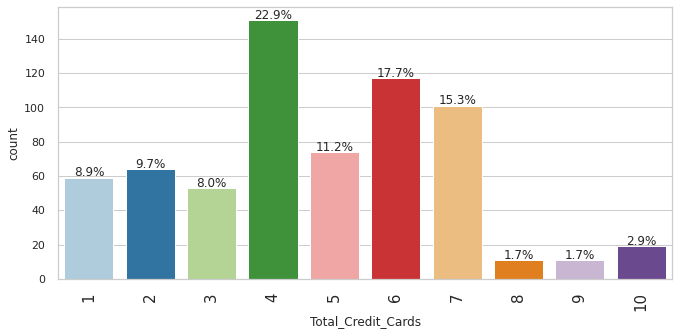

In [ ]:
labeled_barplot(ccardDf, 'Total_Credit_Cards', perc=True)

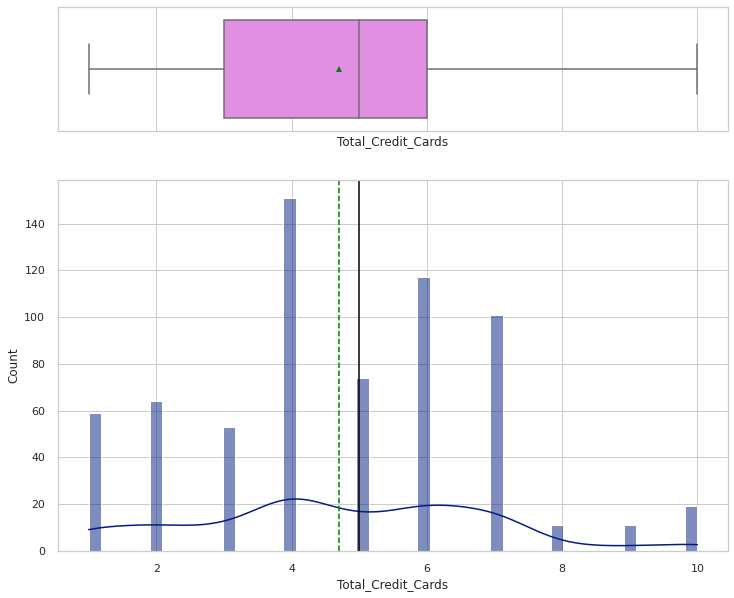

In [ ]:
histogram_boxplot(ccardDf, 'Total_Credit_Cards', bins=50, kde=True, figsize=(12, 10))

**Observations:**
- ~ 22.9% of customers hold 4 credit cards
- ~ 17.7% and 15.3% of customers hold 6 and 7 credit cards respectively.
- ~ 9.7%, 8.9 and 8.0% of customers hold 2 , 1 and 3 credit cards respectively.
- ~ 2.9% of customers hold 10 credit cards.
- cutomers holding 8 or 9 cards are very few ~1.7%
- There are no outliers in this data.

#### Observations on Total_visits_bank

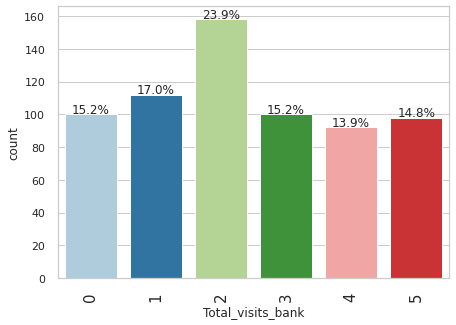

In [ ]:
labeled_barplot(ccardDf, 'Total_visits_bank', perc=True)

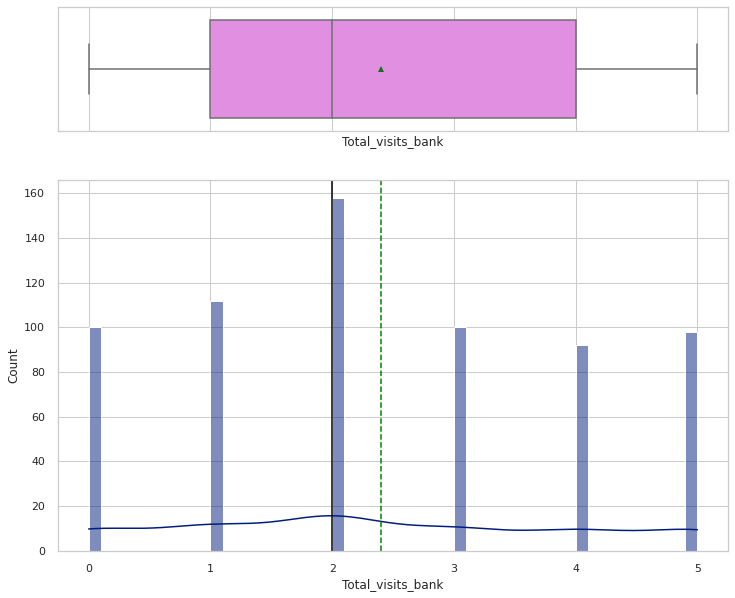

In [ ]:
histogram_boxplot(ccardDf, 'Total_visits_bank', bins=50, kde=True, figsize=(12, 10))

**Observations:**
- ~ 22.9% of customers hold 4 credit cards
- ~ 17.7% and 15.3% of customers hold 6 and 7 credit cards respectively.
- ~ 9.7%, 8.9 and 8.0% of customers hold 2 , 1 and 3 credit cards respectively.
- ~ 2.9% of customers hold 10 credit cards.
- cutomers holding 8 or 9 cards are very few ~1.7%
- There are no outliers in this data.

#### Observations on Total_visits_online

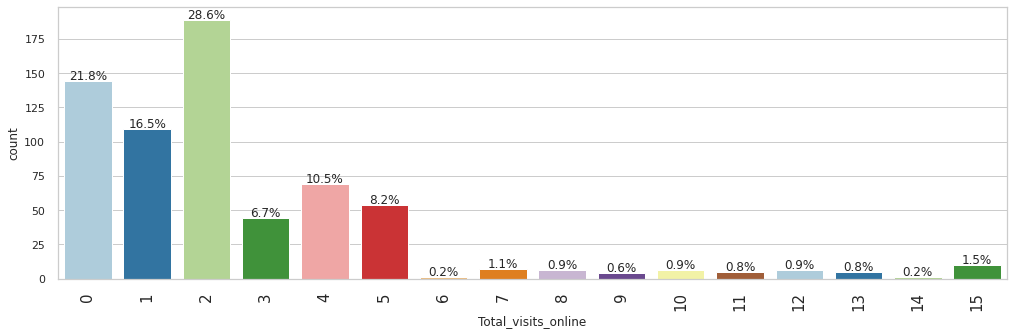

In [ ]:
labeled_barplot(ccardDf, 'Total_visits_online', perc=True)

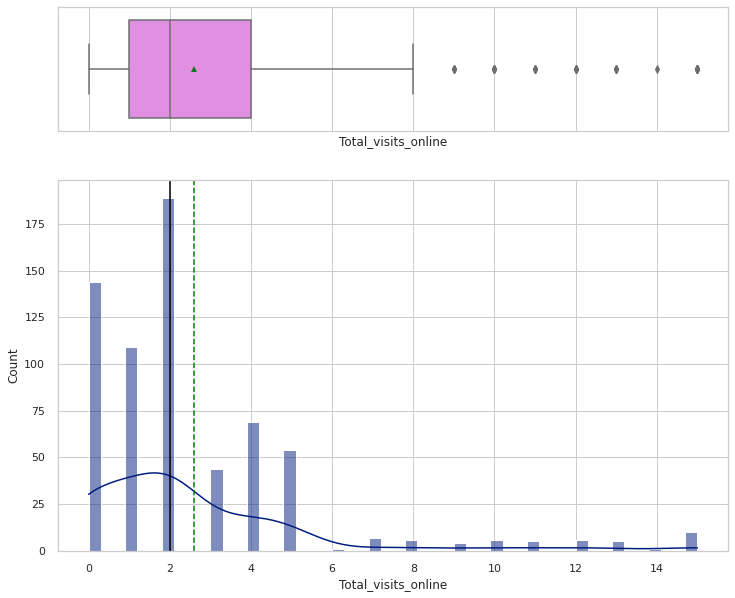

In [ ]:
histogram_boxplot(ccardDf, 'Total_visits_online', bins=50, kde=True, figsize=(12, 10))

**Observations:**
`Total_visits_online`
- ~ 21.8% of customers never did online banking.
- ~ 28.6% of customers have logged in twice.
- ~ 16.5% of customers have logged in only once.
- ~ 10.5% of customers have logged in 4 times.
- ~ 6.7% of customers have logged in 3 times.
- ~ 8.2% of customers have loggedin 5 times.
- ~ Customers who have logged in more than 6 times are ~1% to 2%.
- Data is more skewed to the right with outliers. It may not be necassarily outliers,
since it looks like most of the customers are not making use of online banking.

#### Observations on Total_calls_made

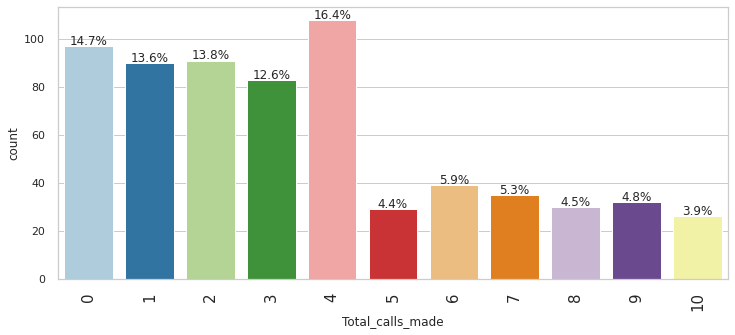

In [ ]:
labeled_barplot(ccardDf, 'Total_calls_made', perc=True)

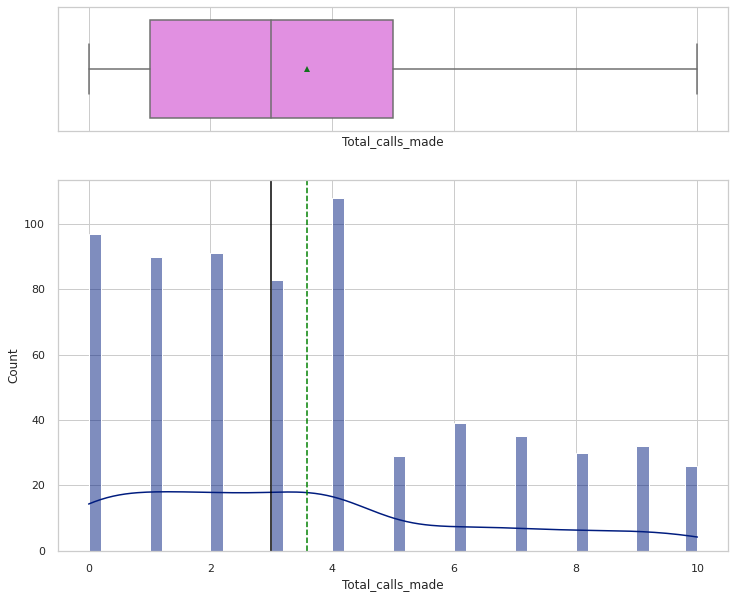

In [ ]:
histogram_boxplot(ccardDf, 'Total_calls_made', bins=50, kde=True, figsize=(12, 10))

**Observations:** `Total_calls_made` 
- ~16.4% of customers made calls 4 times.
- ~14.7 of customers never made any call.
- ~13.6 of customers made calls one and twice.
- ~4% to 5% of customers made calls more than 5 times.

#### Observations on Avg_Credit_Limit

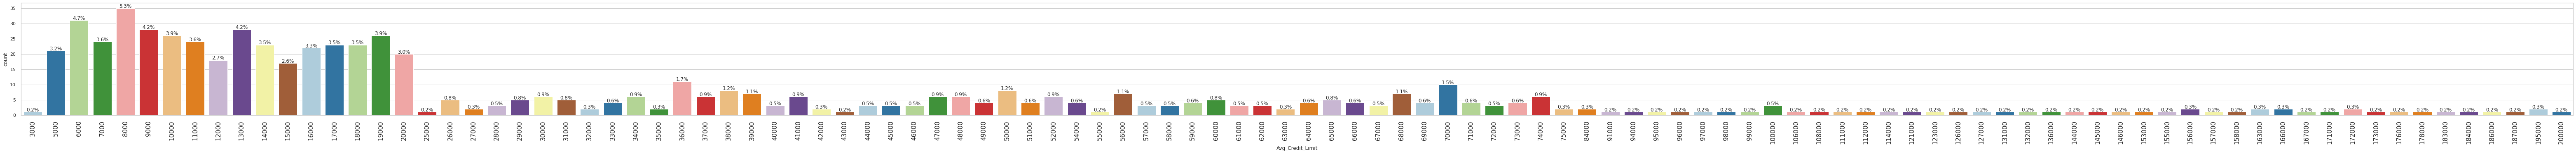

In [ ]:
labeled_barplot(ccardDf, 'Avg_Credit_Limit', perc=True)

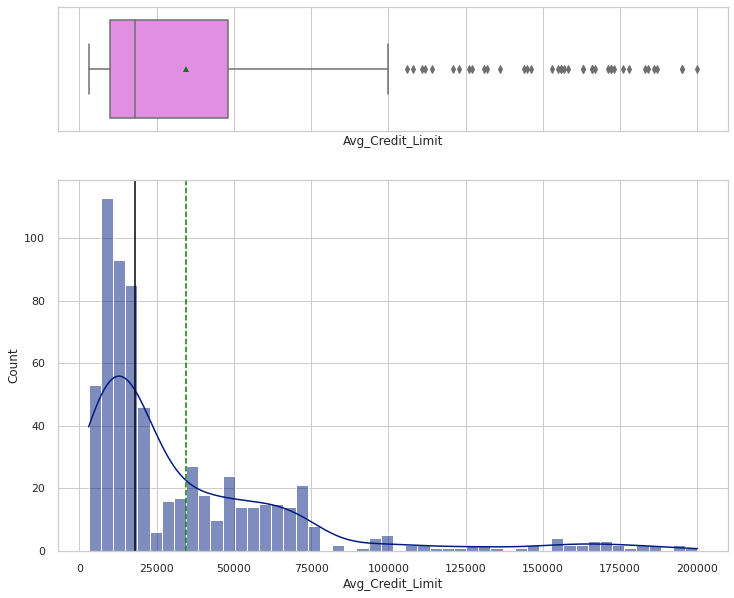

In [ ]:
histogram_boxplot(ccardDf, 'Avg_Credit_Limit', bins=50, kde=True, figsize=(12, 10))

**Observations** `Avg_Credit_Limit`

`Total_calls_made` 
- ~16.4% of customers made calls 4 times.
- ~14.7 of customers never made any call.
- ~13.6 of customers made calls one and twice.
- ~4% to 5% of customers made calls more than 5 times.
`Avg_Credit_Limit`
- ~3% to 5% of customers have Average credit limit between 5K and 20K.
- There are lot of customers who have credit limit more than 25K, 
but they are spread across different ranges from 25K to 200K.
- Data is severly skewed to the right.
- Bolx plot shows several outliers beyond 25K, we will analyze futher and decide what to do with this data.



### CDF Plot

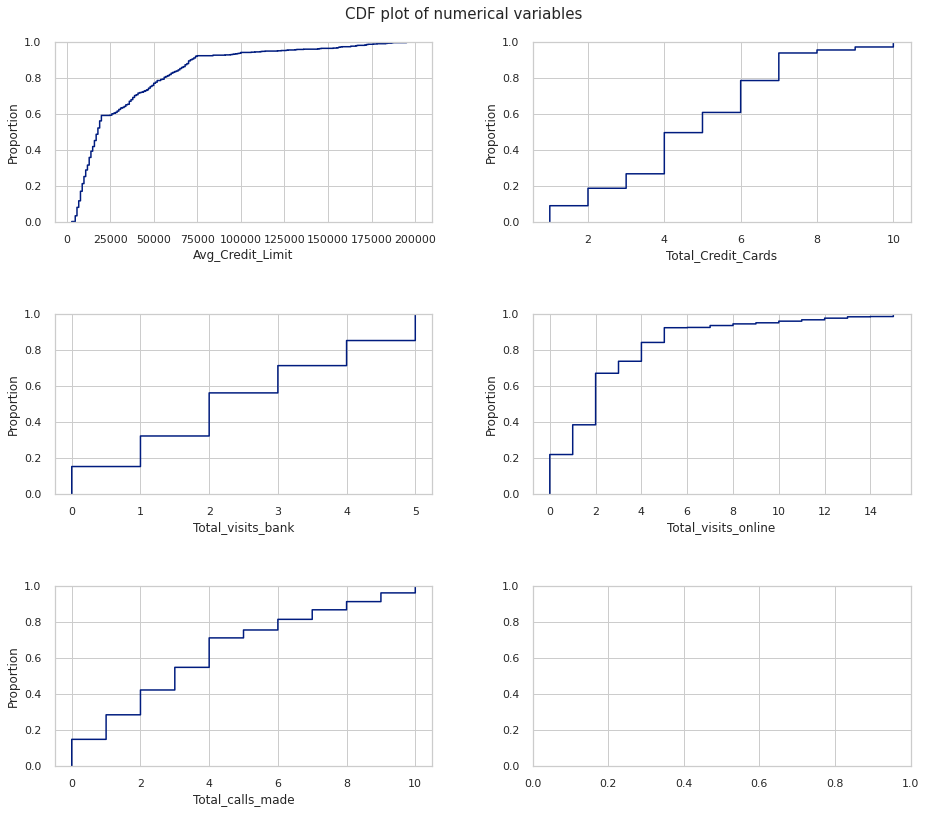

In [ ]:
num_col = ccardDf.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("CDF plot of numerical variables", fontsize=15)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=ccardDf[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=ccardDf[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=4.0)

**Observations**

CDF Plot:

- Approximately 60% of customers have Average credit limit less than 25K
- Approximately 90% of customers have credit limit more than 75K

- Approximately 80% of customers have 7 credit cards and ~95% of customers have more than 8 credit cards.

- Approximately 82% of customers vist the bank more than 4 times and 60% of customers visit the bank 3 times.

- Approximately 80% to 90% of customers made calls to the bank 6 to 8 times.
and 90% of customers made calls to the bank more than 8 times.




### Multivariate Analysis

#### Correlation Matrix

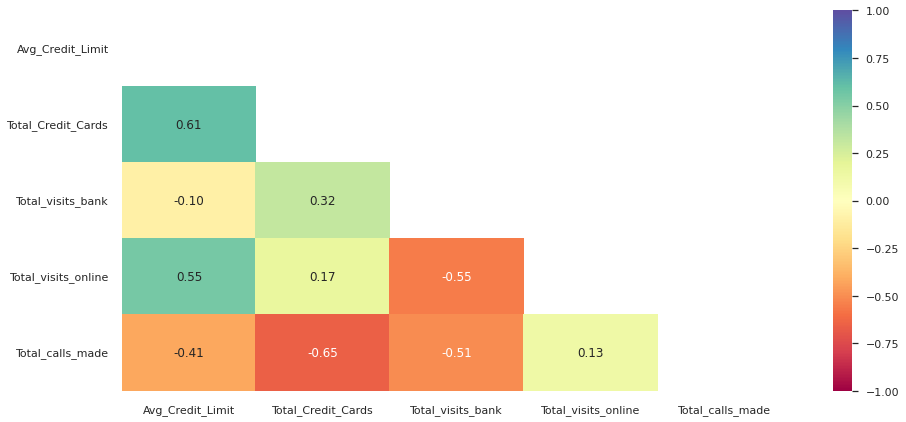

In [ ]:
plt.figure(figsize=(15, 7))
corr= ccardDf.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True,vmin=-1, vmax=1, fmt=".2f", mask=matrix, cmap='Spectral')
plt.show()


**Observations:**

- `Total_Credit_Cards` and `Average_Cregit_Limit` have a strong positive correlation, which implies that the customers having more credit cards tend to have more credit limit.
- `Total_Visits_Online` also tend to have a strong positive correlation with `Average_Credit_Limit` which implies customers having more credit limit prefer to use online banking.
- `Total_Visits_online` and `Total_visits_bank` have a strong negative correlation which implies that the customers using online banking might not prefer going to the bank.
- `Total_calls_made` has a strong negative correlation with rest of the columns but shows a slightly positive correlation with `Total_visits_online` column.
- I prefer to keep all the columns for my clustering and analysis as the data set has only a few variables.


**Since the data set here is small and the focus of this project is to build KMeans and Hierarchical clusters and compare them, I am choosing to keep all the fields.**

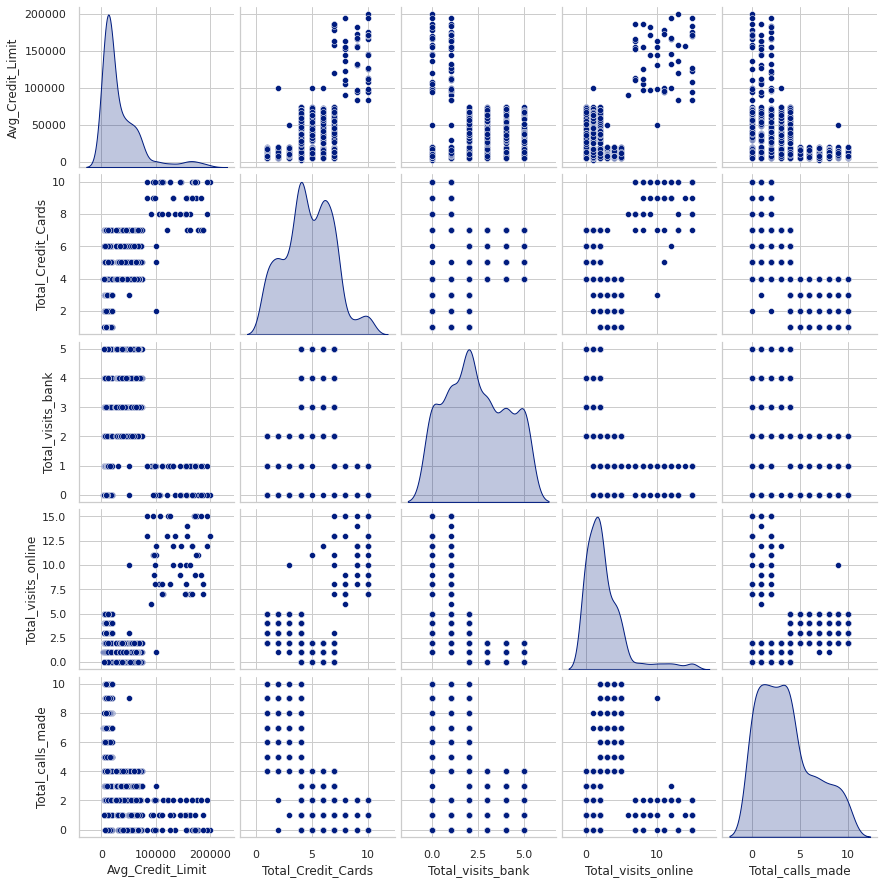

In [ ]:
# sns.set_palette(sns.color_palette("dark"))
sns.pairplot(data=ccardDf[num_col], diag_kind="kde", corner=False)
plt.show()

**Observations**
- From the above pair plot we can see that the Guassian curve has several humps, the data is not linear and unevenly distributed. 

#### Customer level analysis

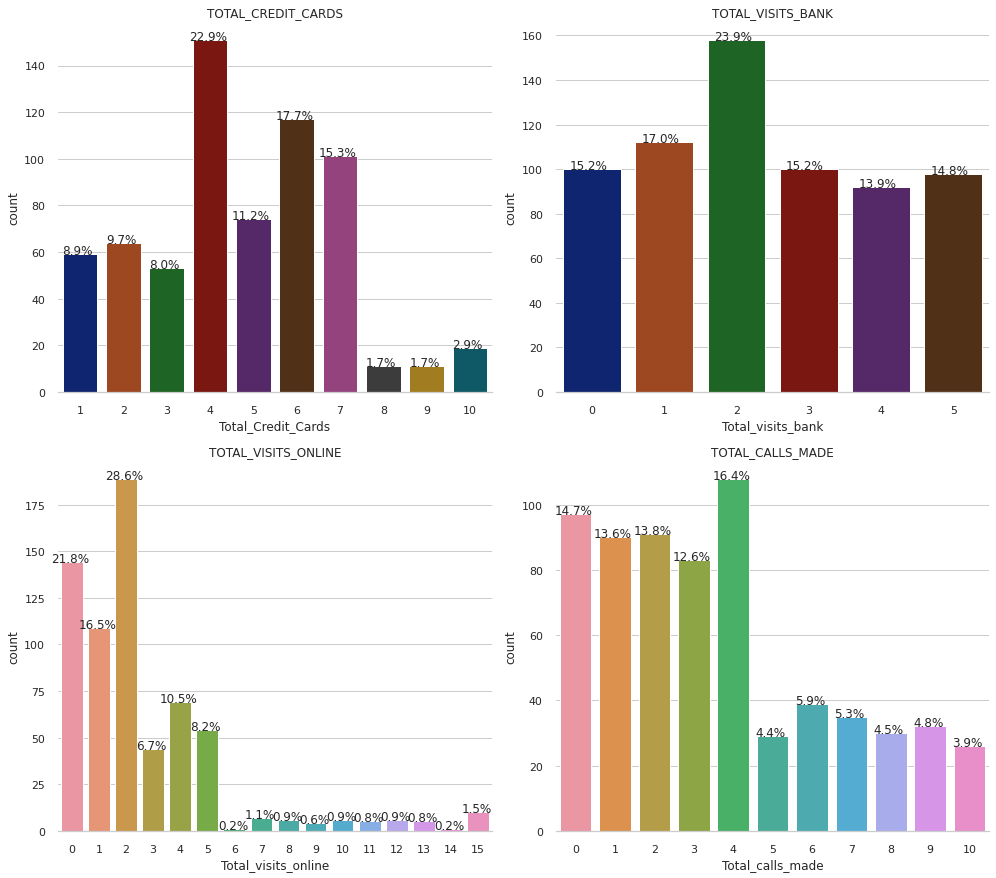

In [ ]:
title= ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
category_cols= ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
plt.figure(figsize=(14,24))
# sns.set_theme(style="white") 
for i, variable in enumerate(category_cols):
                     plt.subplot(4,2,i+1)
                     order = ccardDf[variable].value_counts(ascending=False).index   
                    #  sns.set_palette('dark')
                     ax=sns.countplot(x=ccardDf[variable], data=ccardDf)
                     sns.despine(top=True,right=True,left=True) # to remove side line from graph
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(ccardDf[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')
                     plt.tight_layout()
                     plt.title(title[i].upper())
                                     

#### Average_credit_limit Vs Total_Credit_Cards

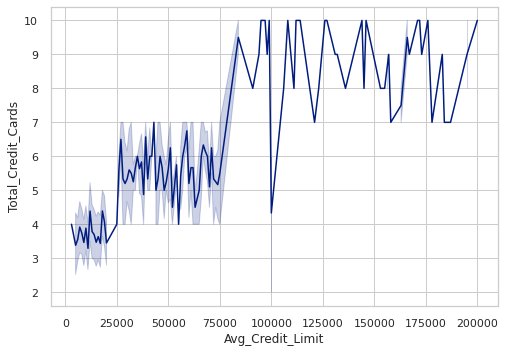

In [ ]:
sns.lineplot(x = "Avg_Credit_Limit", y = "Total_Credit_Cards", data = ccardDf)
plt.show()

**Observations:**
- Cutomers who have more than 7 credit cards have Average credit limit more than 75K.
- Customers who have 5 or less credit cards have Average_Credit_Limit less than 25K.
- Customers who have 6 to 7 credit cards have Average_Credit_Limit between 25K and 75K.
- There are some customers who have Avg_Credit limit in 100K range and having 4 to 7 credit cards.

#### Average_credit_limit Vs Total_calls_made

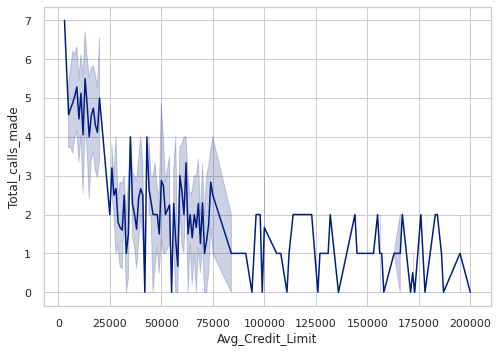

In [ ]:
sns.lineplot(x = "Avg_Credit_Limit", y = "Total_calls_made", data = ccardDf)
plt.show()

**Observations:**
- Customers having less than 25K avg_credit limit made more calls compared to the ones having avg_credit_limit more than 25K.


#### Total_Credit_Cards Vs Total_visits_online

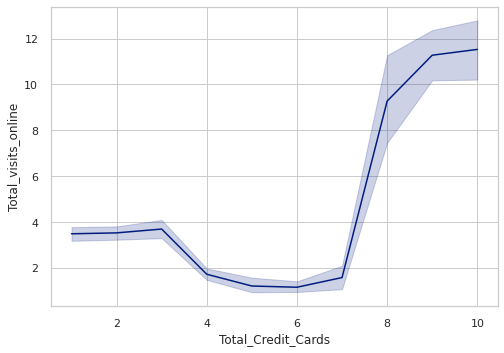

In [ ]:
sns.lineplot(x = "Total_Credit_Cards", y = "Total_visits_online", data = ccardDf)
plt.show()

**Observations:**
- Customers having 7 or more credit cards used online banking more than the ones who had less credit cards.
- Customers having 4 to 7 credit cards seem to be using online banking minimally.

#### Total_Credit_Cards Vs Total_visits_bank

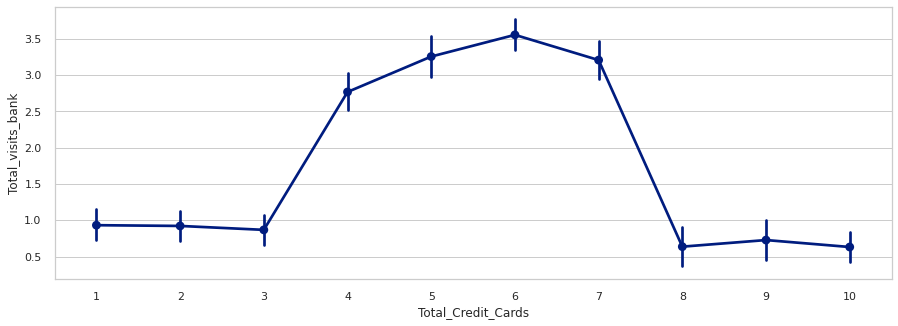

In [ ]:
plt.figure(figsize=(15,5))
sns.pointplot(x="Total_Credit_Cards", y="Total_visits_bank",  data=ccardDf)
plt.show()

**Observations:**
- Custmers having 4 to 8 credit cards seem to be visiting the bank more often than the rest of them.


#### Total_Credit_Cards Vs Total_calls_made

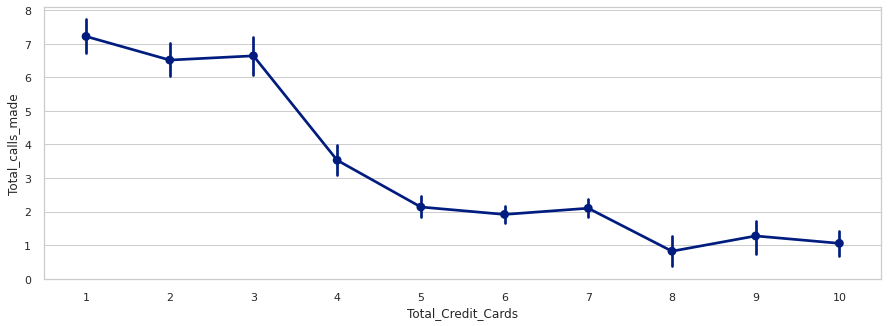

In [ ]:
plt.figure(figsize=(15,5))

sns.pointplot(x="Total_Credit_Cards", y="Total_calls_made",  data=ccardDf)
plt.show()

**Observations:**

- Customers having less number of cards ie., 1 to 3 cards seem to be doing more calls than the customers who have more than 4 cards.

#### Total_calls_made Vs Total_visits_bank

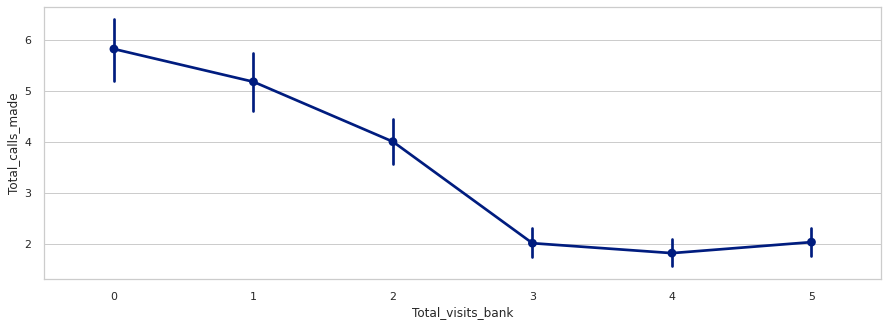

In [ ]:
plt.figure(figsize=(15,5))
sns.pointplot(x="Total_visits_bank", y="Total_calls_made",  data=ccardDf)
plt.show()

**Summary of EDA**
- The data type of all the variables in this data set is integer.
- We dropped Sl.No and Customer Key column as they do not have any significance in clustering.
- There were 5 customer keys duplicated, we kept the records and dropped the customer key column as this data might provide some insight for clustering.

`Total_Credit_Cards`
- ~ 22.9% of customers hold 4 credit cards
- ~ 17.7% and 15.3% of customers hold 6 and 7 credit cards respectively.
- ~ 9.7%, 8.9 and 8.0% of customers hold 2 , 1 and 3 credit cards respectively.
- ~ 2.9% of customers hold 10 credit cards.
- cutomers holding 8 or 9 cards are very few ~1.7%

`Total_visits_bank`
- ~ 23.9% of customers have visited the bank twice
- ~ 17% of customers have visited the bank once.
- ~ 15% to 14% percentage of customers have visited the bank 3,4 or 5 times
- ~ 15.2% of customers never visited the bank.

`Total_visits_online`
- ~ 21.8% of customers never did online banking.
- ~ 28.6% of customers have logged in twice.
- ~ 16.5% of customers have logged in only once.
- ~ 10.5% of customers have logged in 4 times.
- ~ 6.7% of customers have logged in 3 times.
- ~ 8.2% of customers have loggedin 5 times.
- ~ Customers who have logged in more than 6 times are ~1% to 2%.
- Data is more skewed to the right with outliers. It may not be necassarily outliers,
since it looks like most of the customers are not making use of online banking.

`Total_calls_made` 
- ~16.4% of customers made calls 4 times.
- ~14.7 of customers never made any call.
- ~13.6 of customers made calls one and twice.
- ~4% to 5% of customers made calls more than 5 times.

`Avg_Credit_Limit`
- ~3% to 5% of customers have Average credit limit between 5K and 20K.
- There are lot of customers who have credit limit more than 25K, 
but they are spread across different ranges from 25K to 200K.
- Data is severly skewed to the right.
- Bolx plot shows several outliers beyond 25K, we will analyze futher and decide what to do with this data.

**CDF Plot:**
- Approximately 60% of customers have Average credit limit less than 25K
- Approximately 90% of customers have credit limit more than 75K

- Approximately 80% of customers have 7 credit cards and ~95% of customers have more than 8 credit cards.

- Approximately 82% of customers vist the bank more than 4 times and 60% of customers visit the bank 3 times.

- Approximately 80% to 90% of customers made calls to the bank 6 to 8 times.
and 90% of customers made calls to the bank more than 8 times.

**Correlation Matrix:**
- `Total_Credit_Cards` and `Average_Cregit_Limit` have a strong positive correlation, which implies that the customers having more credit cards tend to have more credit limit.
- `Total_Visits_Online` also tend to have a strong positive correlation with `Average_Credit_Limit` which implies customers having more credit limit prefer to use online banking.
- `Total_Visits_online` and `Total_visits_bank` have a strong negative correlation which implies that the customers using online banking might not prefer going to the bank.
- `Total_calls_made` has a strong negative correlation with rest of the columns but shows a slightly positive correlation with `Total_visits_online` column.
- I prefer to keep all the columns for my clustering and analysis as the data set has only a few variables.

**Customer Level Analysis:**

- Cutomers who have more than 7 credit cards have Average credit limit more than 75K.
- Customers who have 5 or less credit cards have Average_Credit_Limit less than 25K.
- Customers who have 6 to 7 credit cards have Average_Credit_Limit between 25K and 75K.
- There are some customers who have Avg_Credit limit in 100K range and having 4 to 7 credit cards.


- Customers having 7 or more credit cards used online banking more than the ones who had less credit cards.
- Customers having 4 to 7 credit cards seem to be using online banking minimally.

- Custmers having 4,6 and 7 credit cards seem to be visiting the bank more often than the rest of them.

- Customers who visited the bank more made less phone calls than the customers who made phone calls.

# Feature Engineering

## Outliers Treatment

### Lets check the percentage of Outliers with IQR

In [ ]:
outlier_num = ccardDf.select_dtypes(include=np.number)

# find the 25th percentile and 75th percentile.
Q1 = ccardDf.quantile(0.25)            
Q3 = ccardDf.quantile(0.75)

# Inter Quantile Range (75th percentile - 25th percentile)
IQR = Q3 - Q1                           

# find lower and upper bounds for all values. All values outside these bounds are outliers
lower=Q1-1.5*IQR                        
upper=Q3+1.5*IQR

df_outliers = pd.DataFrame(((outlier_num<lower)|(outlier_num>upper)).sum()/len(ccardDf)*100)
df_outliers

,0
Avg_Credit_Limit,5.909091
Total_Credit_Cards,0.000000
Total_visits_bank,0.000000
Total_visits_online,5.606061
Total_calls_made,0.000000


**Observations**

- *Avg_Credit_Limit* and *Total_Visits_online* are the only columns which have outliers.
- I am choosing not to treat these outliers as they can be grouped into a cluster.

### Scaling

- Scaling is a method of standardization that’s most useful when working with a dataset that contains continuous features that are on different scales, and you’re using a model that operates in some sort of linear space. Since the Avg_Credit_Limit is in a different scale, we will use StandardScalar function to scale all the variables to a common standard before applying clusters.

In [ ]:
# scaling the data before clustering
scaler = StandardScaler()
subset = ccardDf.copy()
subset_scaled = scaler.fit_transform(subset)

In [ ]:
# creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

In [ ]:
kMeansDf = subset_scaled_df.copy() #Make a copy of the scaled data to retain this scaled copy for Hierarchical clustering

#### Selecting K using Elbow method

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620169
Number of Clusters: 6 	Average Distortion: 0.9426543606899347
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.8843243844476886


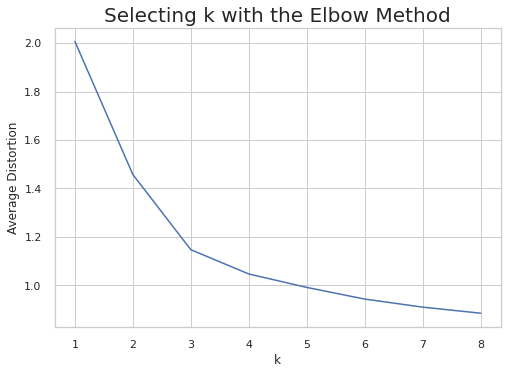

In [ ]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(kMeansDf)
    distortion = (
        sum(np.min(cdist(kMeansDf, model.cluster_centers_, "euclidean"), axis=1))
        / kMeansDf.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

**From the above chart we can see that there is a clear Elbow at cluster number 3, there is also a slight elbow at 2, let us check the silhoutte score and see which is a good number of clusters**

#### Selecting K using silhoutte scores

In [ ]:
sil_score = []
cluster_list = range(2, 10)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((kMeansDf))
    score = silhouette_score(kMeansDf, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.255906765297388)
For n_clusters = 7, the silhouette score is 0.24798644656011146)
For n_clusters = 8, the silhouette score is 0.2414240144760896)
For n_clusters = 9, the silhouette score is 0.2184645050755029)


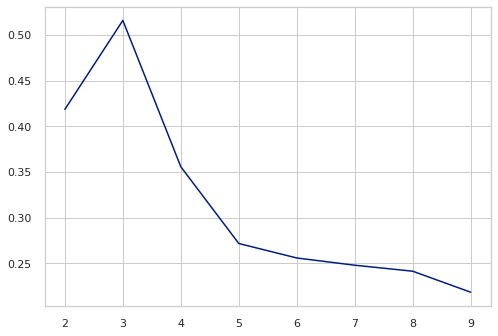

In [ ]:
plt.plot(cluster_list, sil_score)
plt.show()

**Cluster number 3 has a good silhoutte score of 0.52 which is higher than the rest of the clusters, so we can consider using 3 clusters.**

- Let us check the silhoutte visualizer for different number of clusters to finalize a good cluster number.

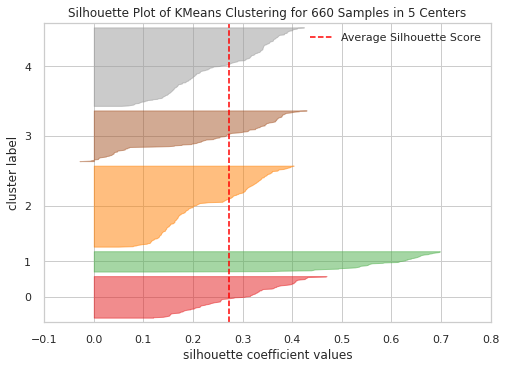

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(kMeansDf)
visualizer.show()

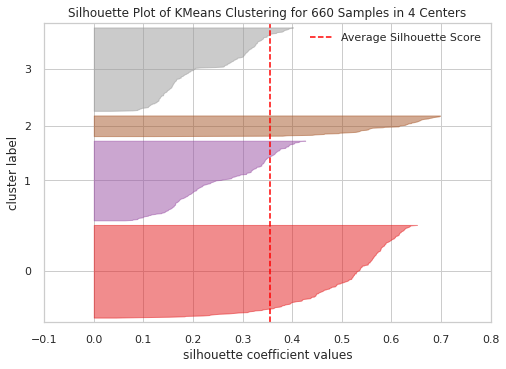

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(kMeansDf)
visualizer.show()

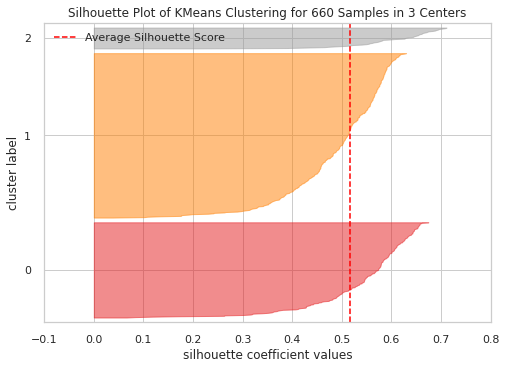

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(kMeansDf)
visualizer.show()

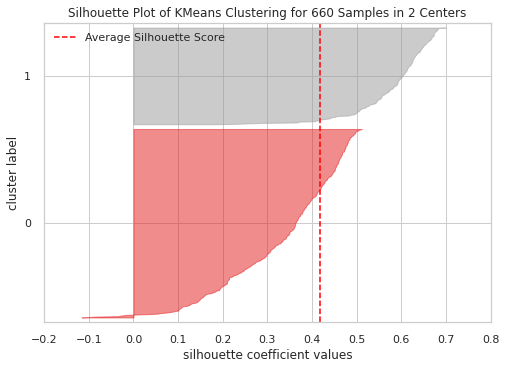

In [ ]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(kMeansDf)
visualizer.show()

**From the above visualization charts 3 seems to be a good cluster number, let us assign 3 to k and see how our model performs**

In [ ]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(kMeansDf)

KMeans(n_clusters=3, random_state=1)

In [ ]:
# adding kmeans cluster labels to the original and scaled dataframes
ccardDf["K_means_segments"] = kmeans.labels_
kMeansDf["K_means_segments"] = kmeans.labels_

**Observations**

- From the above chart we can see that there is a clear Elbow at cluster number 3, there is also a slight elbow at 2, let us check the silhoutte score and see which is a good number of clusters
- Cluster number 3 has a good silhoutte score of 0.52 which is higher than the rest of the clusters, so we can consider using 3 clusters.
- From the silhoutte visualization charts 3 seems to be a good cluster number, let us assign 3 to k and see how our model performs

## K-means Cluster Profiling

##### Using Mean

In [ ]:
kMeansCluster = ccardDf.groupby("K_means_segments").median()

In [ ]:
kMeansCluster["count_in_each_segment"] = (
    ccardDf.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
# let's display cluster profiles
kMeansCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12000.000000,2.000000,1.000000,4.000000,7.000000,224
1,31000.000000,6.000000,3.000000,1.000000,2.000000,386
2,145500.000000,9.000000,1.000000,11.000000,1.000000,50


##### Using Median

In [ ]:
kMeansCluster = ccardDf.groupby("K_means_segments").mean()

In [ ]:
kMeansCluster["count_in_each_segment"] = (
    ccardDf.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
# let's display cluster profiles
kMeansCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


**There is no major difference between mean and median, I will consider using mean.**

##### Cluster visualization on scaled data

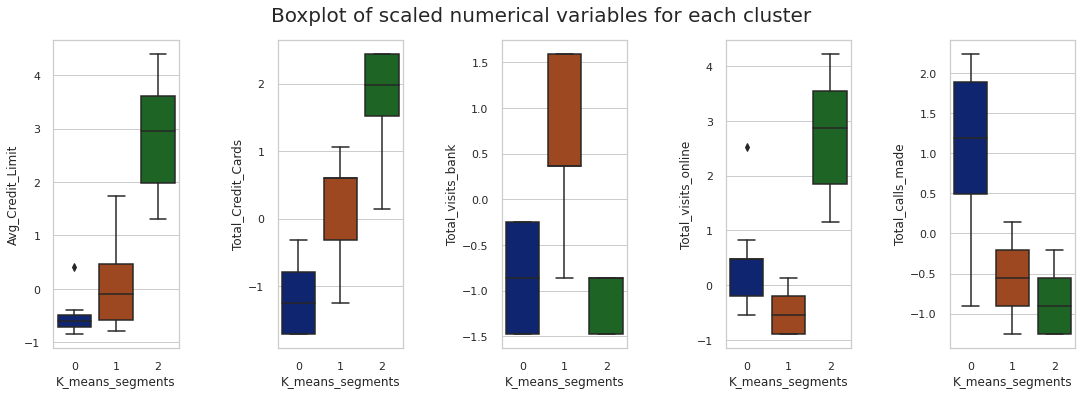

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=kMeansDf[num_col[counter]],
        x=kMeansDf["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=3.5)

##### Cluster visualization on original data

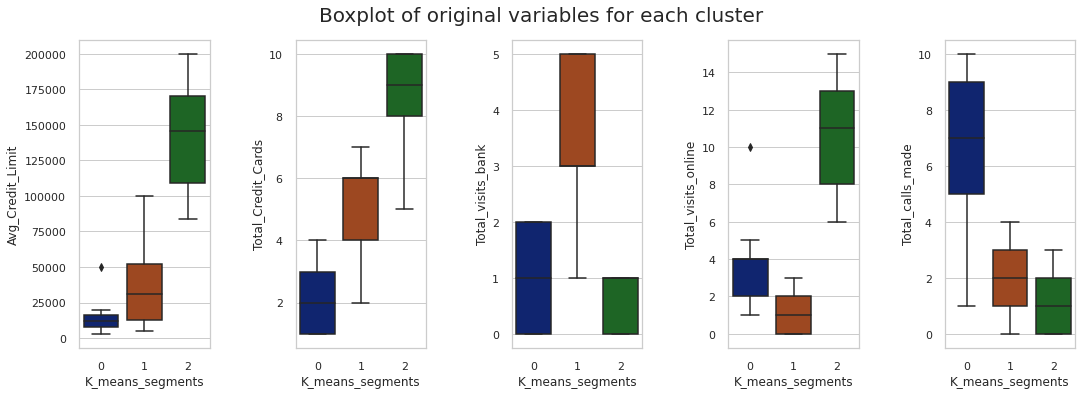

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ccardDf[num_col[counter]],
        x=ccardDf["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=3.5)

**Observations:**
* **`Average_credit_limit`**
  - Customers whose Average_Credit_Limit is less than 25K are grouped in cluster number 0, with one outlier whose average credit limit is around 50K.
  - Customers with Average_credit_limit approximately between 20K and a little above 50K fall into cluster number 1.
  - Rest of them with Average_credit_limit above 100K fall into cluster number 

* **`Total_Credit_Cards`**
  - Customers holding less than 3 credit cards are grouped into cluster number 0.
  - Customers holding 4 to 6 credit cards are grouped into cluster number 1.
  - Customers holding 8 to 10 credit cards are grouped into cluster number 2.

* **`Total_visits_bank`**
  - Customers did not visit the bank and upto 2 visits are grouped into cluster number 0.
  - Customers who made 3 to 5 visits to bank are grouped into cluster number 1.
  - Customers who made 0 or 1 visit to bank are also grouped into cluster number 2.

* **`Total_visits_online`**
  - Customers who visited online 2 to 4 times are grouped into cluster number 0, with one outlier visiting 10 times.
  - Customers who did not do any online visit and who visited online upto 2 times are grouped into cluster number 1.
  - Customers who visited online more than 8 times are gouped into cluster number 2.

* **`Total_calls_made`**
  - Customers who made more than 5 calls are grouped in cluster number 0.
  - Customers who made 1 or 3 calls are grouped in cluster number 1.
  - Customers who did not make any call and made upto 2 calls are grouped into cluster number 2

## Hierarchical Clustering

In [ ]:
HCdf = subset_scaled_df.copy()

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(HCdf, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(HCdf))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(HCdf, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(HCdf))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827492.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print()
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**


**Let's view the dendrograms for the different linkage methods.**

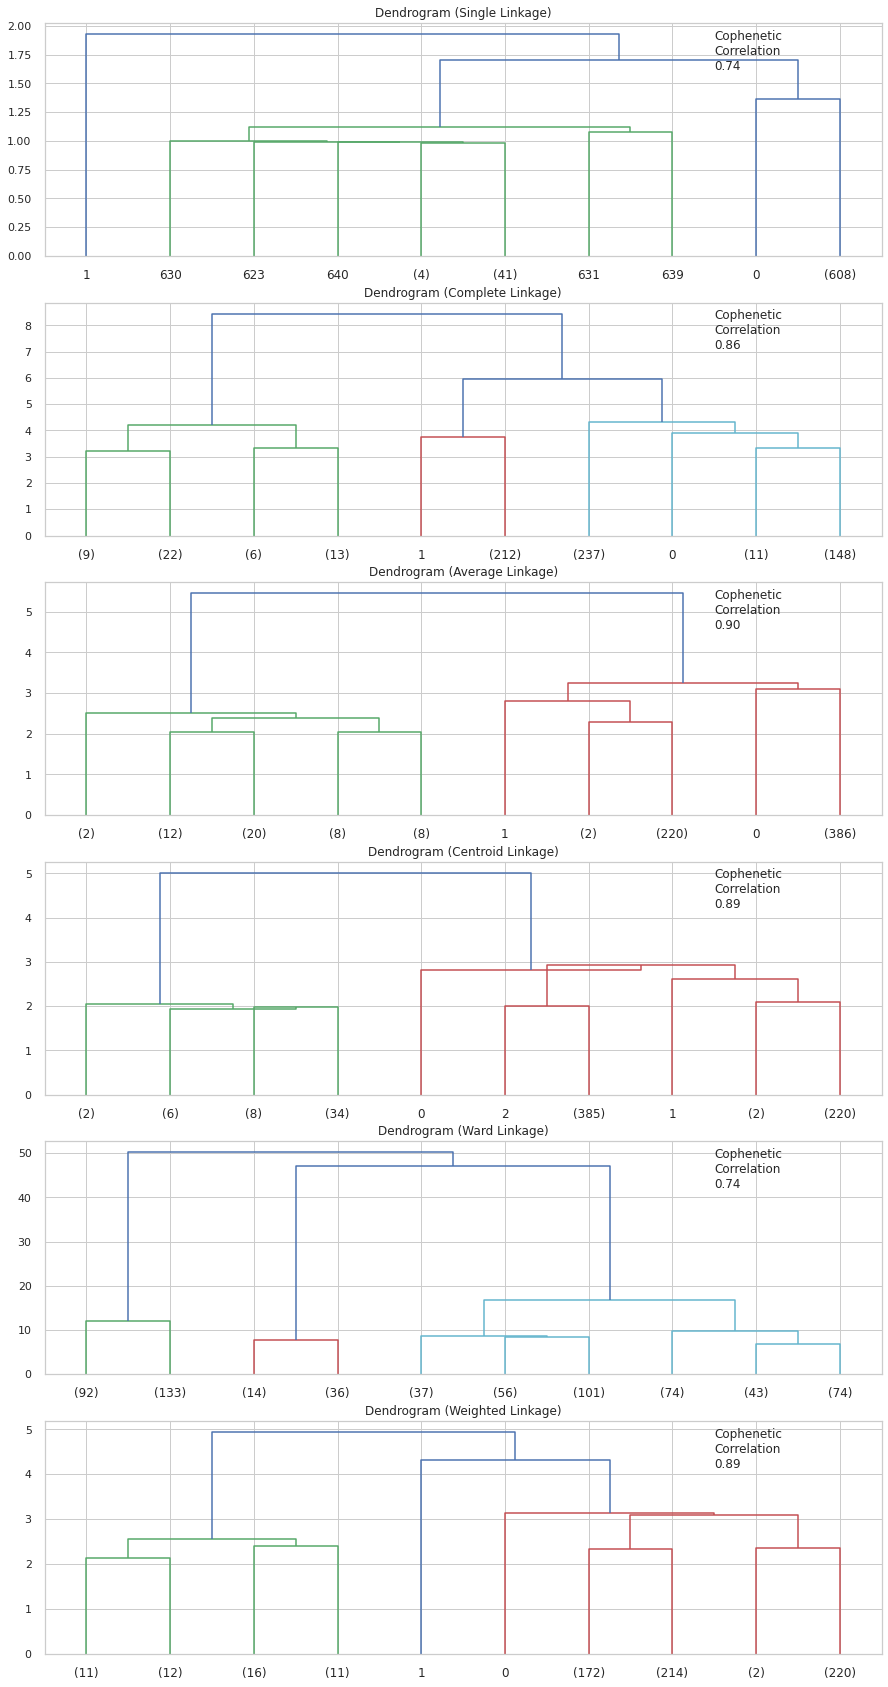

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["DistanceMetric","LinkageMethod", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(HCdf, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i],p=10,truncate_mode="lastp")
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(HCdf))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append(["euclidean",method, coph_corr])

In [ ]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,DistanceMetric,LinkageMethod,Cophenetic Coefficient
0,euclidean,single,0.739122
4,euclidean,ward,0.741516
1,euclidean,complete,0.859973
5,euclidean,weighted,0.886175
3,euclidean,centroid,0.893939
2,euclidean,average,0.897708


**Dendrogram using `average linkage` has the highest Cophenetic Coefficient and shows distinct and equally clustered tree.**

**We will also create dendrogram for Mahalanobis and Manhattan distances with average and weighted linkage methods having the highest Cophenetic Coefficients.**

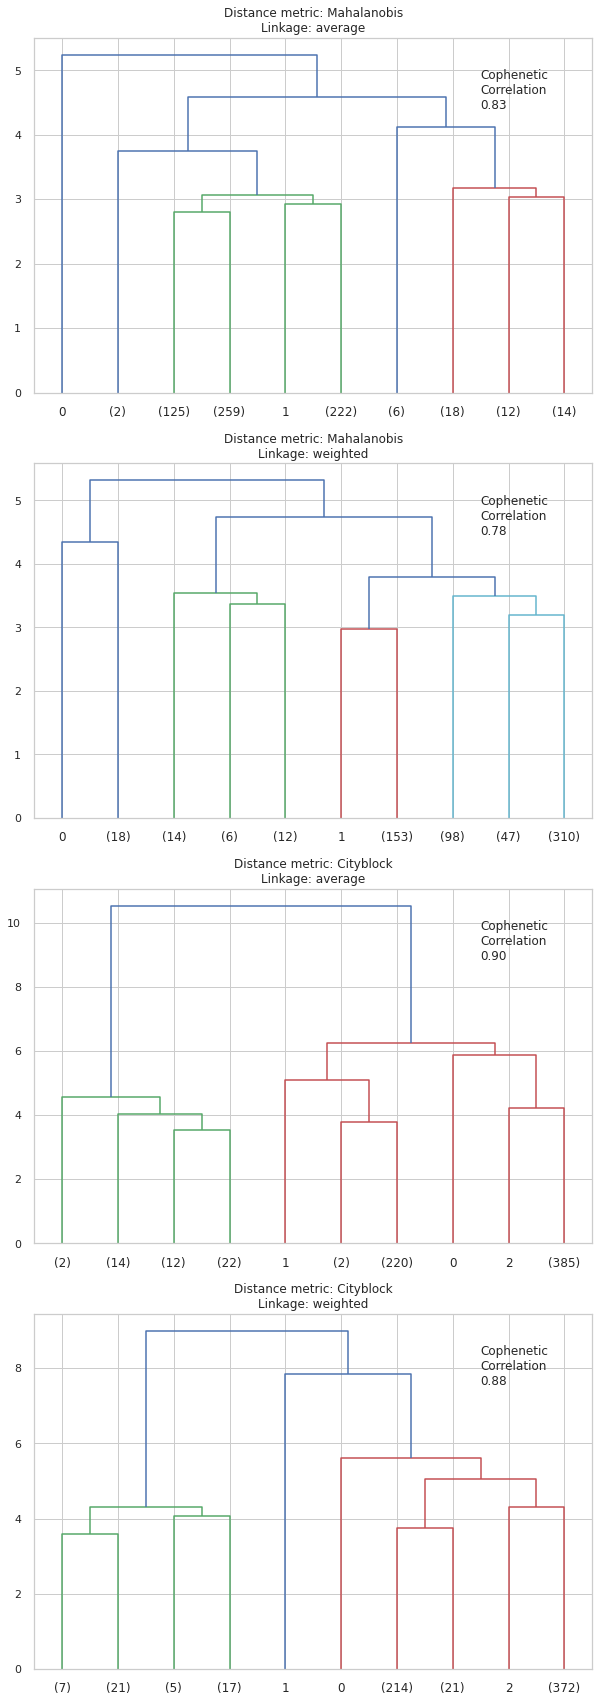

In [ ]:
# list of distance metrics
distance_metrics = ["mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]
# compare_cols = ["DistanceMetric","LinkageMethod", "Cophenetic Coefficient"]
# compare = []

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i],p=10,truncate_mode="lastp")
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1
        compare.append([dm,lm,coph_corr])

In [ ]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,DistanceMetric,LinkageMethod,Cophenetic Coefficient
0,euclidean,single,0.739122
4,euclidean,ward,0.741516
7,mahalanobis,weighted,0.780599
6,mahalanobis,average,0.832699
1,euclidean,complete,0.859973
9,cityblock,weighted,0.882552
5,euclidean,weighted,0.886175
3,euclidean,centroid,0.893939
8,cityblock,average,0.896329
2,euclidean,average,0.897708


**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with `average linkage` using `euclidean` distance metric is giving a separate and distinct clusters and highest `Cophenetic Correlation` value.
- 3 would be the appropriate number of the clusters from the dendrogram with `average linkage` method. 

**Based on the above results, we will choose to use Euclidean distance with average linkage method for our final clustering as it gives the maximum Cophenetic Correlation value, also chossing, number of clusters = 3 seems to be a good cluster groupig.**

In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(HCdf)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [ ]:
# creating a copy of the original data
HCdf["HC_segments"] = HCmodel.labels_
ccardDf["HC_segments"] = HCmodel.labels_

In [ ]:
HCdf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1


In [ ]:
ccardDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_segments
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,1


## Hierarchical Cluster Profiling

##### Using Median

In [ ]:
HCCluster = HCdf.groupby("HC_segments").median()

In [ ]:
HCCluster["count_in_each_segment"] = (
    HCdf.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
HCCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,-0.095067,0.597334,0.366110,-0.547490,-0.553005,387
1,2.950391,1.982253,-0.860451,2.861408,-0.902271,50
2,-0.600427,-1.249225,-0.860451,0.475180,1.193326,223


##### Using Mean

In [ ]:
HCCluster = HCdf.groupby("HC_segments").mean()

In [ ]:
HCCluster["count_in_each_segment"] = (
    HCdf.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [ ]:
HCCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,-0.022902,0.371882,0.664034,-0.552775,-0.551200,387
1,2.831764,1.862226,-1.105763,2.827319,-0.874330,50
2,-0.595179,-1.062913,-0.904453,0.325372,1.152605,223


Using Mean and Median are giving similar results, I am choosing to use Mean.

##### Cluster visualization on scaled data

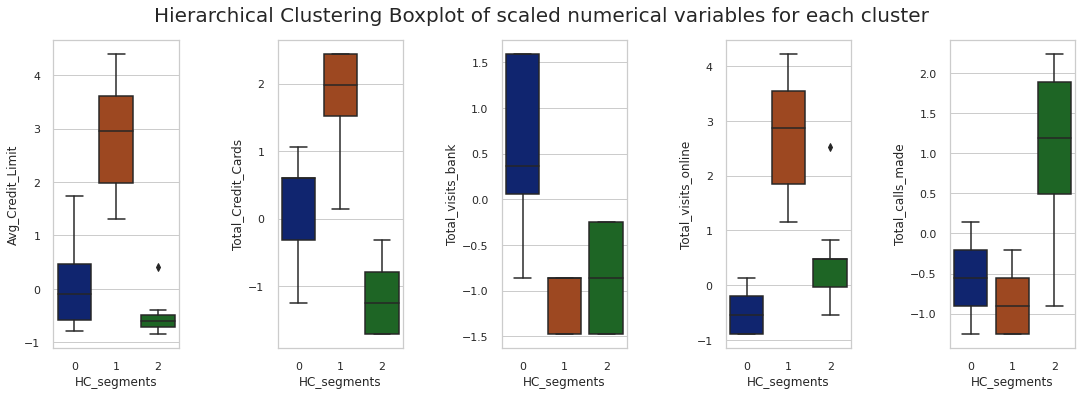

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Hierarchical Clustering Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=HCdf[num_col[counter]],
        x=HCdf["HC_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=3.5)

##### Cluster visualization on original data

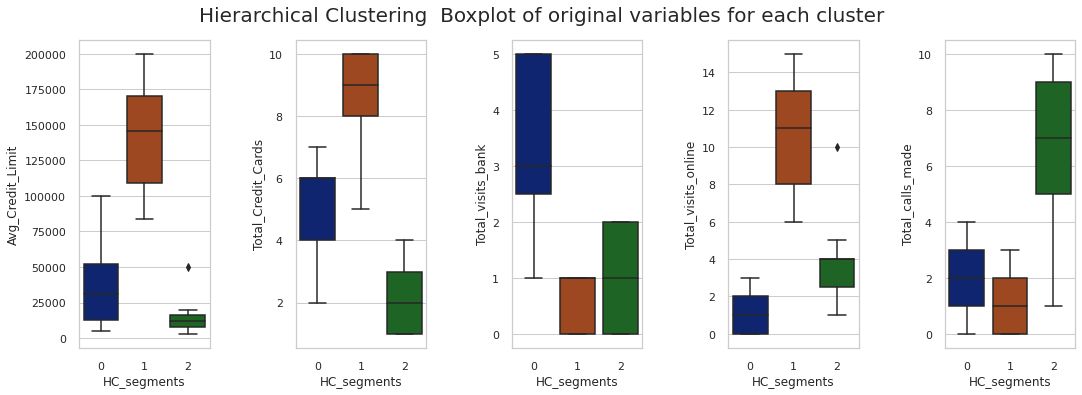

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Hierarchical Clustering  Boxplot of original variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ccardDf[num_col[counter]],
        x=ccardDf["HC_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=3.5)

**Observations:**
* **`Average_credit_limit`**
  - Customers whose Average_Credit_Limit is less than 25K are grouped in cluster number 2, with one outlier whose average credit limit is around 50K.
  - Customers with Average_credit_limit approximately between 20K and a little above 50K fall into cluster number 0.
  - Rest of them with Average_credit_limit above 100K fall into cluster number 1. 

* **`Total_Credit_Cards`**
  - Customers holding less than 3 credit cards are grouped into cluster number 2.
  - Customers holding 4 to 6 credit cards are grouped into cluster number 0.
  - Customers holding 8 to 10 credit cards are grouped into cluster number 1.

* **`Total_visits_bank`**
  - Customers did not visit the bank and upto 2 visits are grouped into cluster number 2.
  - Customers who made 3 to 5 visits to bank are grouped into cluster number 0.
  - Customers who made 0 or 1 visit to bank are also grouped into cluster number 1.

* **`Total_visits_online`**
  - Customers who visited online 2 to 4 times are grouped into cluster number 2, with one outlier visiting 10 times.
  - Customers who did not do any online visit and who visited online upto 2 times are grouped into cluster number 0.
  - Customers who visited online more than 8 times are gouped into cluster number 1.

* **`Total_calls_made`**
  - Customers who made more than 5 calls are grouped in cluster number 2.
  - Customers who made 1 or 3 calls are grouped in cluster number 0.
  - Customers who did not make any call and made upto 2 calls are grouped into cluster number 1.

## Comparing K-Means Clustering and Hierarchical Clustering

- K-Means and Hierarchical clustering are giving the same results, except that the cluster numbers are interchanged.
- Dendograms took a little longer to plot in hierarchical clustering, I don't see any drawback since the data set is limited.

#### Comparing Scaled Data

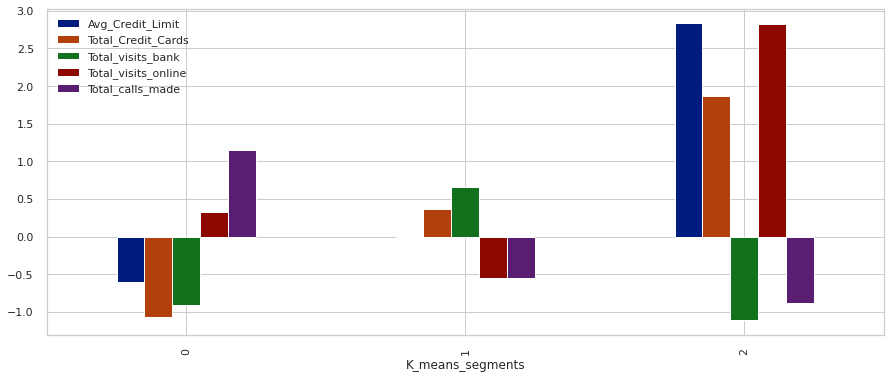

In [ ]:
kMeansDf.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

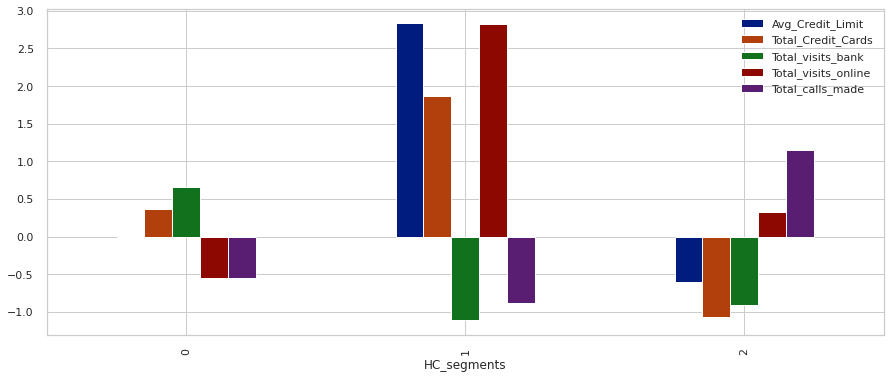

In [ ]:
HCdf.groupby("HC_segments").mean().plot.bar(figsize=(15, 6))

#### Comparing original Data

I am dividing the Avg_Credit_limit value by 10000 for better visualization, however the scaled data is used for interpretation purpose.

In [ ]:
profilingDf = ccardDf.copy()

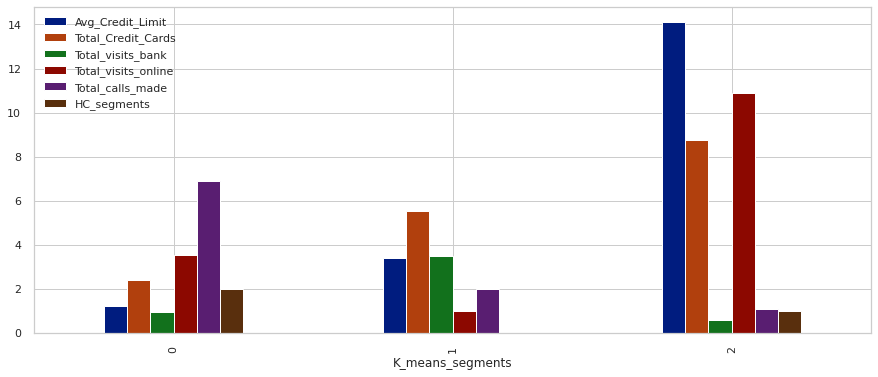

In [ ]:
profilingDf["Avg_Credit_Limit"] = profilingDf.Avg_Credit_Limit/10000
profilingDf.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

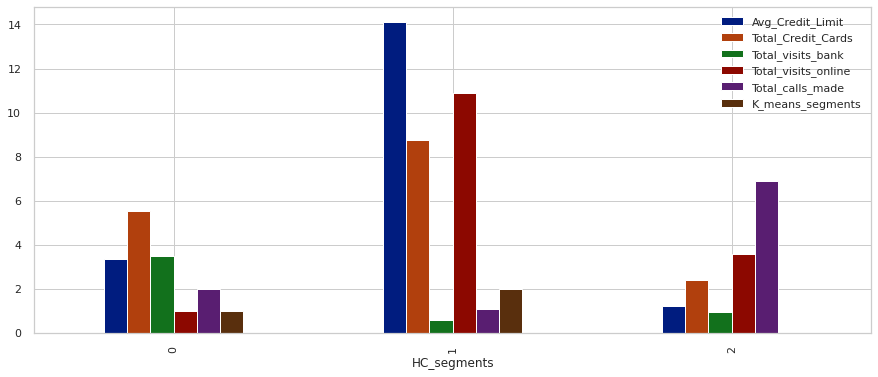

In [ ]:
profilingDf.groupby("HC_segments").mean().plot.bar(figsize=(15, 6))

In [ ]:
ccardDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_segments
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,2
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,1


**Let us label K-means and HC clusters with the same number for better interpretation and comparison between clusters**

In [ ]:
ccardDf.HC_segments = ccardDf.K_means_segments
ccardDf.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_segments
0,100000,2,1,1,0,1,1
1,50000,3,0,10,9,0,0
2,50000,7,1,3,4,1,1
3,30000,5,1,1,4,1,1
4,100000,6,0,12,3,2,2


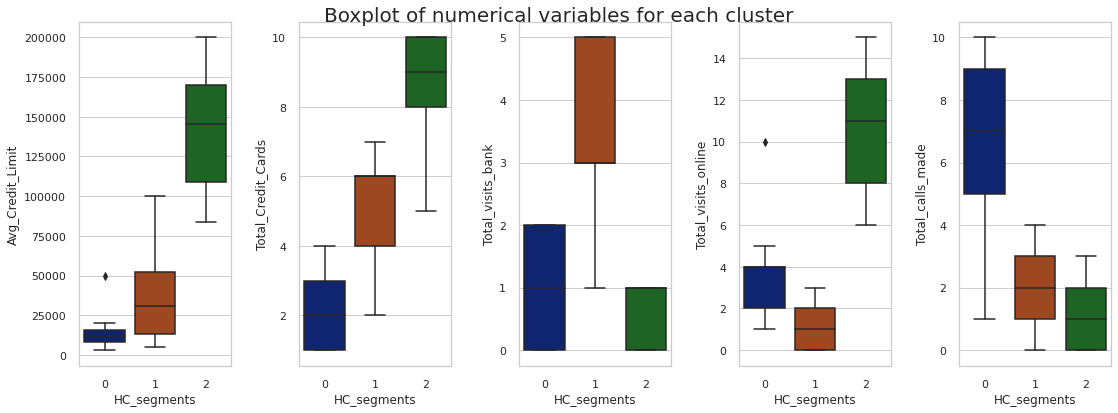

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=ccardDf[ccardDf.columns[counter]], x=ccardDf["HC_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Cluster Comparison

**Cluster 0:**
- Customers whose Average_Credit_Limit is less than 25K are grouped in cluster number 0, with one outlier whose average credit limit is around 50K.
- Customers holding less than 3 credit cards are grouped into cluster number 0.
- Customers did not visit the bank and upto 2 visits are grouped into cluster number 0.
- Customers who visited online 2 to 4 times are grouped into cluster number 0, with one outlier visiting 10 times.
- Customers who made more than 5 calls are grouped in cluster number 0.
- Customers in this cluster made more visits to the bank and had credit limit less than 50K and carried 4 to 6 credit cards,  they did not make much use of online and call services.

**Cluster 1:**
- Customers with Average_credit_limit approximately between 20K and a little above 50K fall into cluster number 1.
- Customers holding 4 to 6 credit cards are grouped into cluster number 1.
- Customers who made 3 to 5 visits to bank are grouped into cluster number 1.
- Customers who did not do any online visit and who visited online upto 2 times are grouped into cluster number 1.
- Customers who made 1 or 3 calls are grouped in cluster number 1.
- Customers in this cluster had good credit limit, carried more than 8 credit cards made more use of online banking serivces.

**Cluster 2:**
- Customers holding 8 to 10 credit cards are grouped into cluster number 2.
- Customers who made 0 or 1 visit to bank are also grouped into cluster number 2.
- Customers who visited online more than 8 times are gouped into cluster number 2.
- Customers who did not make any call and made upto 2 calls are grouped into cluster number 2
- Rest of them with Average_credit_limit above 100K fall into cluster number 2.
- Customers in this cluster had less than 23K credit limit, made fewer phone calls and fewer visits to the bank. They took advantage of online banking better than the customers in cluster 0, however they made more phone calls than the rest of the group.

## Actionable Insights & Business Recommendations


- Bank should learn from the trend of customers in cluster 1, they had more credit limit and carried more than 8 credit cards and made use of online banking,
these customers are very important to the bank, so the bank should take care of retaining these customers and provide them promotions and discounts.

- Bank dhould focus on customers in cluster 0 and help them make use of online and phone services more than inperson visits.
 This will make the customer happy and also reduce the time and resources at the bank.

- Bank should focus on customers in cluster number 2 to help them reduce the number of phone calls and take advantage of online banking services.
Also the bank should focus on attracting these customers to buy more credit cards and increase their credit limit by providing some offers.

- Additionally, bank should verify and see if there are any unresolved issues with the customers who are making more phone calls and in person visits to the bank.